# Paprastas neuroninis tinklas sentimentų analizei

In [1]:
import re, os, string, json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm, trange
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# naudosime Keras
from tensorflow import keras

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
contractions = {
  "ain't": 'am not',
  "aren't": 'are not',
  "can't": 'cannot',
  "'cause": 'because',
  'cause': 'because',
  "could've": 'could have',
  "couldn't": 'could not',
  "couldn't've": 'could not have',
  "daren't": 'dare not',
  "didn't": 'did not',
  "doesn't": 'does not',
  "don't": 'do not',
  "everybody's": 'everybody is',
  "everyone's": 'everyone is',
  'gimme': 'give me',
  'gonna': 'going to',
  'gotta': 'got to',
  "hadn't": 'had not',
  "had've": 'had have',
  "hasn't": 'has not',
  "haven't": 'have not',
  "he'd": 'he had',
  "he'll": 'he will',
  "he's": 'he has',
  "he've": 'he have',
  "how's": 'how is',
  "i'd": 'i had',
  "i'd've": 'i would have',
  "i'll": 'i will',
  "i'm": 'i am',
  'imma': 'i am about to',
  "i've": 'i have',
  "isn't": 'is not',
  "it'd": 'it would',
  "it'll": 'it will',
  "it's": 'it is',
  "let's": 'let us',
  "might've": 'might have',
  "mustn't": 'must not',
  "mustn't've": 'must not have',
  "must've": 'must have',
  "needn't": 'need not',
  "shalln't": 'shall not',
  "shan't": 'shall not',
  "she'd": 'she had',
  "she'll": 'she will',
  "she's": 'she is',
  "should've": 'should have',
  "shouldn't": 'should not',
  "shouldn't've": 'should not have',
  "somebody's": 'somebody is',
  "someone's": 'someone is',
  "something's": 'something is',
  "that'll": 'that will',
  "that're": 'that are',
  "that's": 'that is',
  "that'd": 'that would',
  "there'd": 'there had',
  "there'll": 'there will',
  "there're": 'there are',
  "there's": 'there is',
  "these're": 'these are',
  "these've": 'these have',
  "they'd": 'they had',
  "they'll": 'they will',
  "they're": 'they are',
  "they've": 'they have',
  "those're": 'those are',
  "those've": 'those have',
  "'tis": 'it is',
  'twas': 'it was',
  'wanna': 'want to',
  "wasn't": 'was not',
  "we'd": 'we had',
  "we'd've": 'we would have',
  "we'll": 'we will',
  "we're": 'we are',
  "we've": 'we have',
  "weren't": 'were not',
  "what'd": 'what did',
  "what'll": 'what will',
  "what're": 'what are',
  "what's": 'what is',
  "what've": 'what have',
  "when's": 'when is',
  "where'd": 'where did',
  "where'll": 'where will',
  "where're": 'where are',
  "where's": 'where is',
  "where've": 'where have',
  "which'd": 'which had',
  "which'll": 'which will',
  "which're": 'which are',
  "which's": 'which is',
  "which've": 'which have',
  "who'd": 'who did',
  "who'd've": 'who would have',
  "who'll": 'who will',
  "who's": 'who is',
  "who've": 'who have',
  "won't": 'will not',
  "would've": 'would have',
  "wouldn't": 'would not',
  "y'all": 'you all',
  "y'all'd've": 'you all would have',
  "y'all're": 'you all are',
  "you'd": 'you would',
  "you'll": 'you will',
  "you're": 'you are',
  "you've": 'you have'
}

In [4]:
filename = 'IMDB Dataset.csv'
raw = pd.read_csv(filename)
raw.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


Rekomenduojama atlikti šiuos žingsnius (dauguma jų jau darėme anksčiau):
- Pašalinti HTML tagus
- Normalizuoti tekstą
- Išskleisti sutrumpinimus (su `contractions` žodynu)
- Pašalinti "keistus" simbolius (kurių nėra `string.printable`)
- Pašalinti STOP žodžius

Tuomet:
- Tokenizuoti ir konvertuoti žodžius į skaičius
- Jei reikia, paversti sentimentus į skaičius
- Įsitikinti, kad visos tokenų eilutės yra vienodo ilgio (išsirinkite ilgį patys, siūloma imti du vidurkius)
  - Per trumpas eilutes reikia prailginti su tuščiais žodžiais
  - Konvertuoti žodžius į skaičius geriau po trumpinimo



In [5]:
stopwords = nltk.corpus.stopwords.words('english')
for i, text in tqdm(enumerate(raw['text']), total=len(raw['text'])):
    text = text.lower()
    for word, expanded in contractions.items():
        if word in text:
            if isinstance(expanded, list):
                expanded = expanded[0]
            text = text.replace(word, expanded)
    if "br" in text:
        text = text.replace("br", "")
    if string.printable in text:
        text = ''.join(filter(lambda x: x in string.printable, text))
    text = ' '.join([word for word in text.split() if word not in stopwords])
    text = text.translate(str.maketrans('', '', string.punctuation))
    raw.at[i, 'text'] = text

100%|██████████| 40000/40000 [00:31<00:00, 1261.26it/s]


In [6]:
tokenizer = nltk.tokenize.regexp.WordPunctTokenizer()

sequences = [tokenizer.tokenize(text) for text in raw['text']]

all_lengths = [len(seq) for seq in sequences]
ROW_LENGTH = int(np.mean(all_lengths) * 2)
print(f"Row length: {ROW_LENGTH}")

word_index = {}
for seq in sequences:
    for word in seq:
        if word not in word_index:
            word_index[word] = len(word_index) + 1

sequences_numeric = [[word_index.get(word, 0) for word in seq] for seq in sequences]

X = np.zeros((len(sequences_numeric), ROW_LENGTH), dtype=int)
for i, seq in enumerate(sequences_numeric):
    length = min(len(seq), ROW_LENGTH)
    X[i, :length] = seq[:length]

y = raw['label'].values

VOCAB_SIZE = len(word_index) + 1
print(f"Vocab size: {VOCAB_SIZE}")

Row length: 247
Vocab size: 146607


## Neuroninio tinklo konstravimas

Tinklas turės:
- Embedding sluoksnį (paversti rėtus į tankius vektorius)
- Paslėptą Dense sluoksnį
- Dropout sluoksnį, kad modelis nepersimokytų
- Galutinį sluoksnį, kuris grąžina klasių tikimybes

In [7]:
ROW_LENGTH = ROW_LENGTH  # įrašykite savo gautą skaičių
VOCAB_SIZE = VOCAB_SIZE  # įrašykite savo gautą skaičių
EMBEDDING_DIM = 128
HIDDEN_DIM = 256

model = keras.Sequential([
    keras.layers.Input(shape=(ROW_LENGTH,)),
    keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(HIDDEN_DIM, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 247, 128)       │    18,765,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 31616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,093,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,860,162 (102.46 MB)

 Trainable params: 26,860,162 (102.46 MB)

 Non-trainable params: 0 (0.00 B)

Paruoškite apmokymo duomenis:

In [8]:
# turi gautis np.ndarray()
X = X
# turi gautis np.ndarray()
y = np.array(raw['label'])
print(f"X type: {type(X)}")
print(f"y type: {type(y)}")

X type: <class 'numpy.ndarray'>
y type: <class 'numpy.ndarray'>


Train-test splitas:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

Apmokame modelį:

In [10]:
history = model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=10,  # maždaug tiek užtenka su siūloma konfiguracija
    verbose=1,
    validation_split=0.1  # galutinai: train=0.8, val=0.1, test=0.1
)

# apmokymas gali užtrukti ~10 min.

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5146 - loss: 1.1355 - val_accuracy: 0.7769 - val_loss: 0.5085
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8260 - loss: 0.4046 - val_accuracy: 0.8528 - val_loss: 0.3433
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9373 - loss: 0.1852 - val_accuracy: 0.8667 - val_loss: 0.3166
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9834 - loss: 0.0763 - val_accuracy: 0.8644 - val_loss: 0.3293
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9965 - loss: 0.0311 - val_accuracy: 0.8594 - val_loss: 0.3494
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9992 - loss: 0.0144 - val_accuracy: 0.8633 - val_loss: 0.3646
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9999 - loss: 0.0071 - val_accuracy: 0.8608 - val_loss: 0.3823
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.8606 - val_loss:

Įvertiname modelio tikslumą:

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Accuracy: 0.863


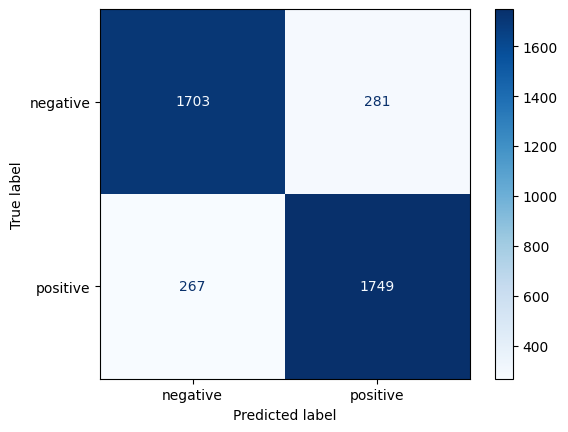

In [11]:
preds = model.predict(X_test)
y_preds = np.argmax(preds, axis=1)  # pabaikite eilutę

print('Accuracy:', accuracy_score(y_test, y_preds))

cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['negative', 'positive'])
disp.plot(cmap='Blues')
plt.show()

Prisiminkite Naive Bayes sentimentų klasifikavimo modelį. Kaip atrodo, ar dabartinis NN modelis yra sėkmingas?

Jei liko laiko, pabandykite modifikuoti tinklą: pridėti ar atimti `Dense` sluoksnį, pridėti `BatchNormalization`, pakeisti ar išimti `Dropout` sluoksnį. Rekurentinių/LSTM sluoksnių dar nenaudokite, bet galite išbantyti Convoliucinnius.

In [12]:
ROW_LENGTH = ROW_LENGTH
VOCAB_SIZE = VOCAB_SIZE
EMBEDDING_DIM = 128
HIDDEN_DIM = 256

model = keras.Sequential([
    keras.layers.Input(shape=(ROW_LENGTH,)),
    keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM
    ),
    keras.layers.Conv1D(128, 5, activation='relu'),
    keras.layers.MaxPooling1D(5),
    keras.layers.Flatten(),
    keras.layers.Dense(HIDDEN_DIM, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 247, 128)       │    18,765,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 243, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,573,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,421,378 (77.90 MB)

 Trainable params: 20,421,378 (77.90 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=4,
    verbose=1,
    validation_split=0.1
)

Epoch 1/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.5129 - loss: 0.7014 - val_accuracy: 0.7908 - val_loss: 0.6102
Epoch 2/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.8250 - loss: 0.5863 - val_accuracy: 0.8783 - val_loss: 0.2971
Epoch 3/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.9294 - loss: 0.1956 - val_accuracy: 0.8889 - val_loss: 0.2809
Epoch 4/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.9753 - loss: 0.0875 - val_accuracy: 0.8850 - val_loss: 0.3418


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
Accuracy: 0.89025


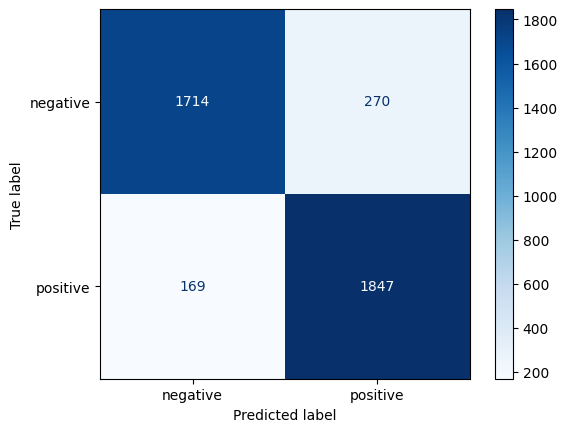

In [14]:
preds = model.predict(X_test)
y_preds = np.argmax(preds, axis=1)  # pabaikite eilutę

print('Accuracy:', accuracy_score(y_test, y_preds))

cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['negative', 'positive'])
disp.plot(cmap='Blues')
plt.show()